In [1]:
from src.config import CACHE_DIR, PERSISTENT_DIR
from src.custom_embeddings import bge_m3_embed, qwen2_embed, nomic_embed
from src.vectorstorage import EmbeddingVectorStorage
import src.utils as utils
print(f"Cache directory: {CACHE_DIR}")

Cache directory: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache


In [2]:
# collection names:
# BAAI_bge_m3_RecursiveCharacterTextSplitter
# Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter
# nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter

# BGE_M3 Embedding Model

In [3]:
# Reload the vector store
bge_m3_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection='BAAI_bge_m3_RecursiveCharacterTextSplitter',
    path_persistent=str(PERSISTENT_DIR)
)

qwen2_vectordb = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection="Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR)
)

nomic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection="nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR)
)

print(f"bge_m3 Heartbeat: {bge_m3_vectordb.test_heartbeat()}, bge_m3 Collection is empty: {bge_m3_vectordb.collection_is_empty()}")
print(f"qwen2 Heartbeat: {qwen2_vectordb.test_heartbeat()}, qwen2 Collection is empty: {qwen2_vectordb.collection_is_empty()}")
print(f"nomic Heartbeat: {nomic_vectordb.test_heartbeat()}, nomic Collection is empty: {nomic_vectordb.collection_is_empty()}")

bge_m3 Heartbeat: 1732223259546557000, bge_m3 Collection is empty: False
qwen2 Heartbeat: 1732223259554896000, qwen2 Collection is empty: False
nomic Heartbeat: 1732223259559591000, nomic Collection is empty: False


In [4]:
from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
from src.evaluation import RAGEvaluation
from dotenv import load_dotenv

load_dotenv()

qwen2_5_3B = 'qwen2.5:3b-instruct'

basic_retriever = bge_m3_vectordb.as_retriever()
local_llm_model = OllamaLLM(model=qwen2_5_3B)

# Initialize the class
openai_llm_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

In [5]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | local_llm_model
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

basic_rag_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-01-12', 'domain': 'solarpowerworldonline', 'origin_doc_id': 'c20859b4d317fade7345d7271336db6b', 'title': 'Entrepreneurs finally bring real sustainability to solar', 'url': 'https://www.solarpowerworldonline.com/2023/01/entrepreneurs-finally-bring-real-sustainability-to-solar/'}, page_content='Back in 2018, one industry source said it was premature to focus on solar panel recycling in the United States, but almost five years later, significant steps are being taken to establish protocols to bring more sustainability to the solar industry. From solar panel recycling to waste cleanup on project sites to better packaging for shipments, the solar industry is greening up its image. , Members of SEIA s PV Recycling Working Group began making recycling checklists and finding preferred partners in 2019, and a grassroots website SolarRecycle.org has collected information on reuse, resale and recycle outlets that accept solar materials. But the bigges

In [6]:
from src.config import CLEAN_FILE_PATH, EVAL_FILE_PATH

baseline_evaluation = RAGEvaluation(
    name="Baseline_BGE_m3_embedding",
    rag_chain=basic_rag_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=bge_m3_embed
)

clean_file_path=str(CLEAN_FILE_PATH)
eval_file_path=str(EVAL_FILE_PATH)

# Perform evaluation
result_baseline = baseline_evaluation.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Baseline_BGE_m3_embedding_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


In [7]:
combined_df = utils.add_to_combined("Baseline_BGE_m3_embedding", result_baseline)

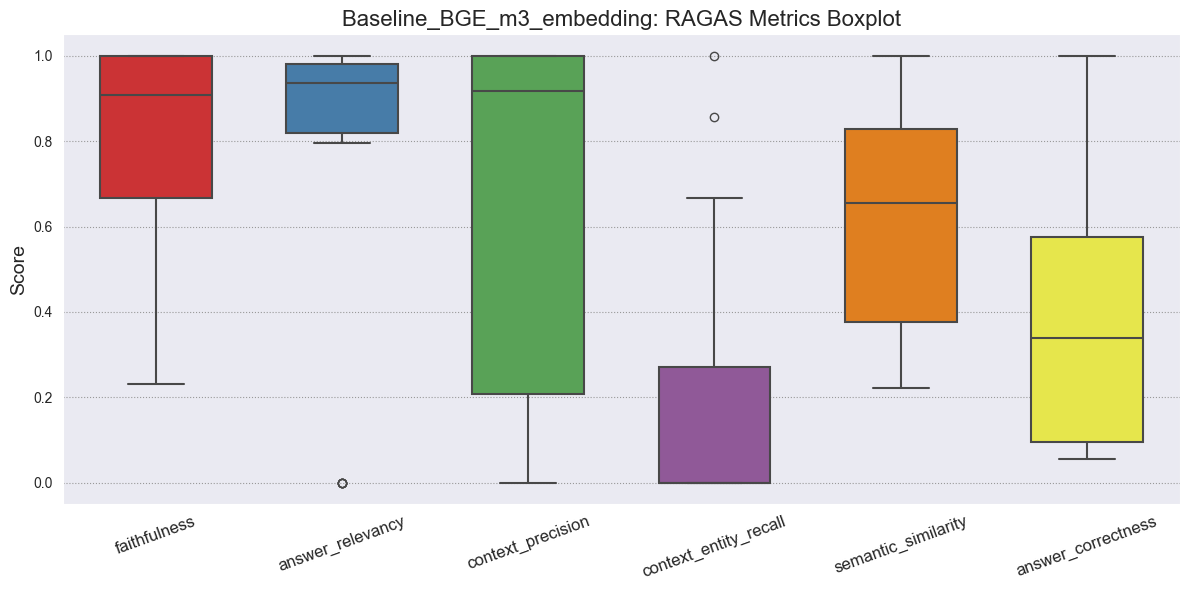

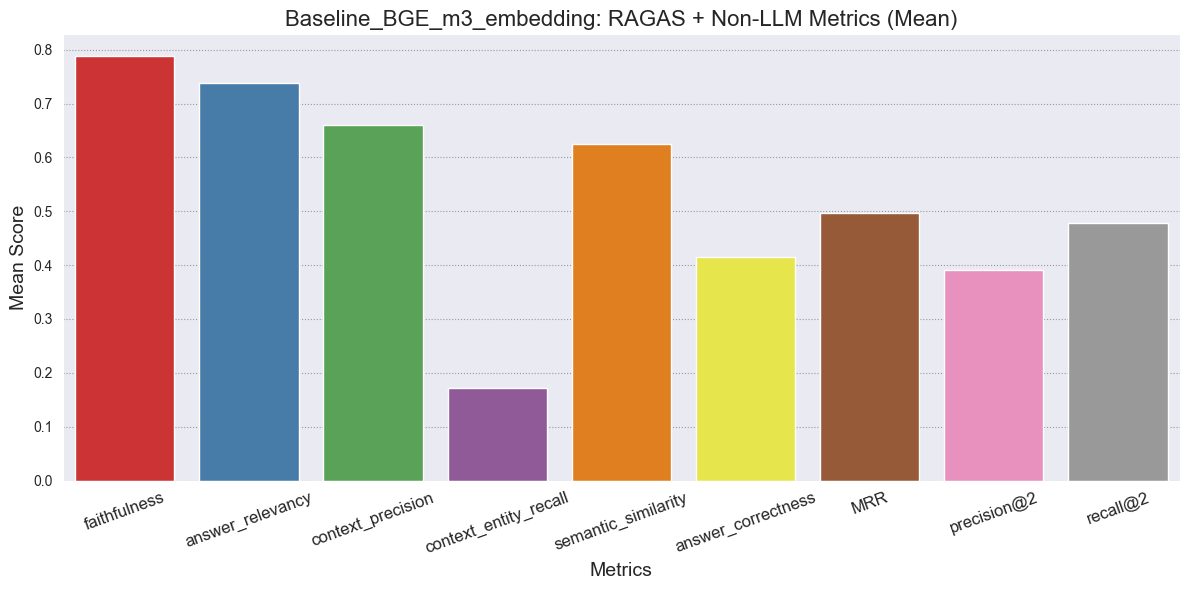

In [8]:
baseline_evaluation.plot_results_all(result_baseline)

# Qwen2 Embedding Model

In [9]:
qwen_retriever = qwen2_vectordb.as_retriever()

qwen_rag_chain = RunnableParallel(
    {"context": qwen_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen_rag_chain.invoke("The company is also aiming to reduce gas flaring?")

{'context': [Document(metadata={'date': '2021-12-06', 'domain': 'naturalgasintel', 'origin_doc_id': '131bdd2d071c7148b6f29f6fb64d3f4b', 'title': 'ExxonMobil Targeting Net Zero Emissions in the Permian by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-targeting-net-zero-emissions-in-the-permian-by-2030/'}, page_content='include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its Permian operations by more than 75 versus 2019, and to eliminate all routine flaring in the basin by the end of 2022. The company is also securing alternative natural gas delivery points across the basin to minimize non routine flaring, management s

In [10]:
embed_model_evaluation = RAGEvaluation(
    name="Experiment_Embedding_Model_Qwen2_5",
    rag_chain=qwen_rag_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=qwen2_embed,
)

In [11]:
result_qwen = embed_model_evaluation.evaluate(clean_file_path, eval_file_path, qwen2_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_Embedding_Model_Qwen2_5_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


In [12]:
combined_df = utils.add_to_combined("Experiment_Embedding_Model_Qwen2_5", result_qwen, combined_df)

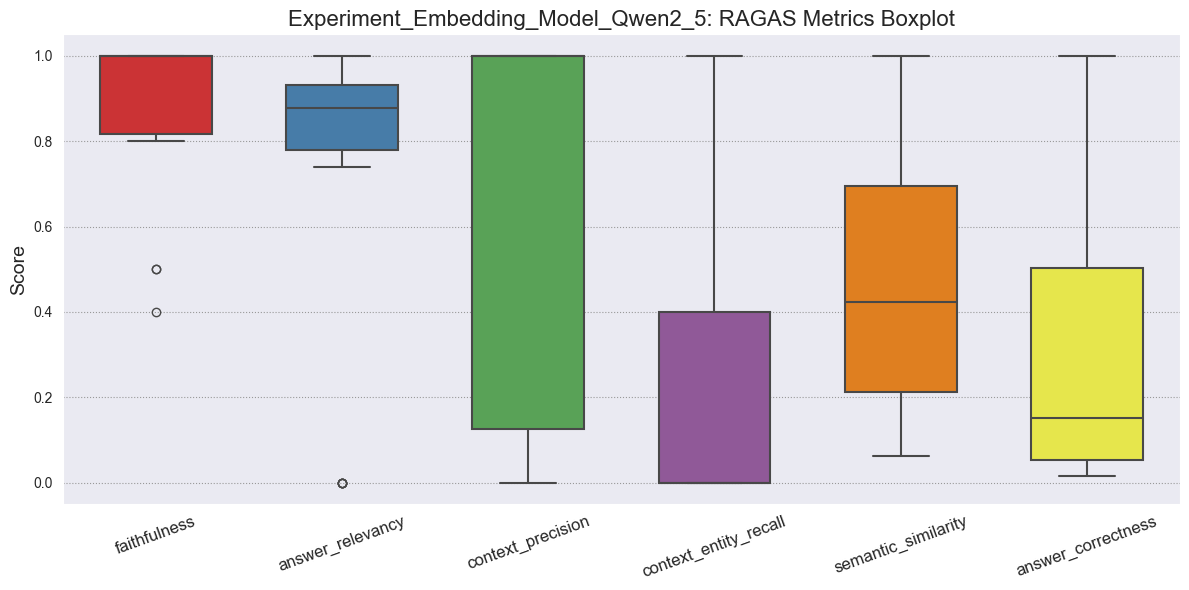

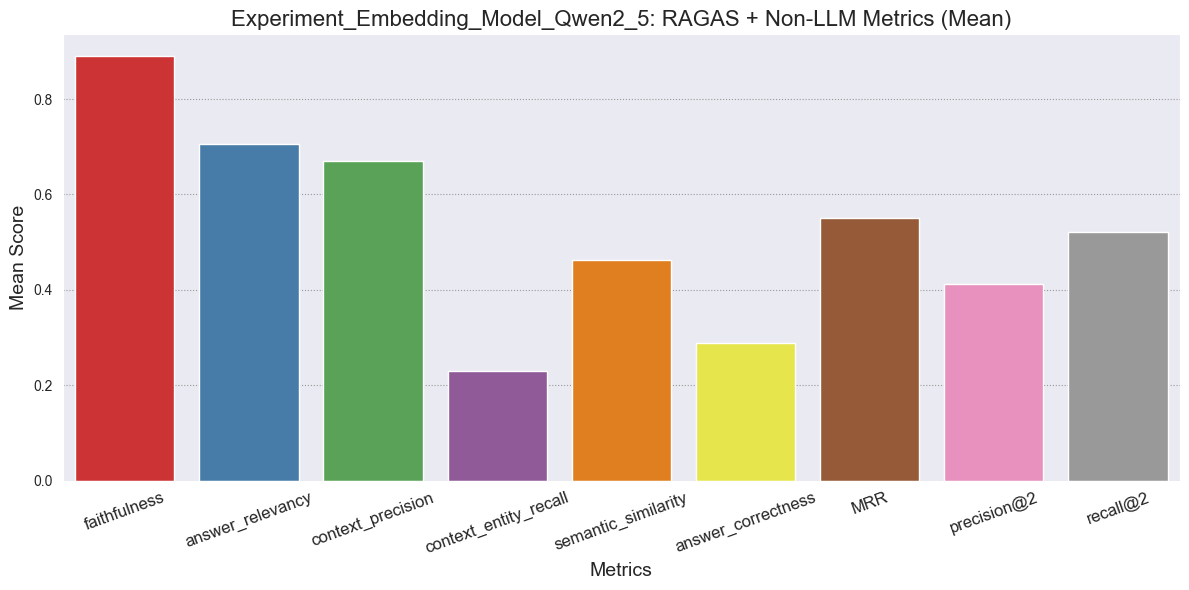

In [13]:
embed_model_evaluation.plot_results_all(result_qwen)

# Nomic Embedding Model

In [14]:
nomic_retriever = nomic_vectordb.as_retriever()

nomic_rag_chain = RunnableParallel(
    {"context": nomic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_rag_chain.invoke("The company is also aiming to reduce gas flaring?")

{'context': [Document(metadata={'date': '2021-12-06', 'domain': 'naturalgasintel', 'origin_doc_id': '131bdd2d071c7148b6f29f6fb64d3f4b', 'title': 'ExxonMobil Targeting Net Zero Emissions in the Permian by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-targeting-net-zero-emissions-in-the-permian-by-2030/'}, page_content='include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its Permian operations by more than 75 versus 2019, and to eliminate all routine flaring in the basin by the end of 2022. The company is also securing alternative natural gas delivery points across the basin to minimize non routine flaring, management s

In [15]:
nomic_model_evaluation = RAGEvaluation(
    name="Experiment_Embedding_Model_Nomic",
    rag_chain=nomic_rag_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=nomic_embed,
)

In [16]:
result_nomic = nomic_model_evaluation.evaluate(clean_file_path, eval_file_path, nomic_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_Embedding_Model_Nomic_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


In [17]:
combined_df = utils.add_to_combined("Embedding_Model_Nomic", result_nomic, combined_df)

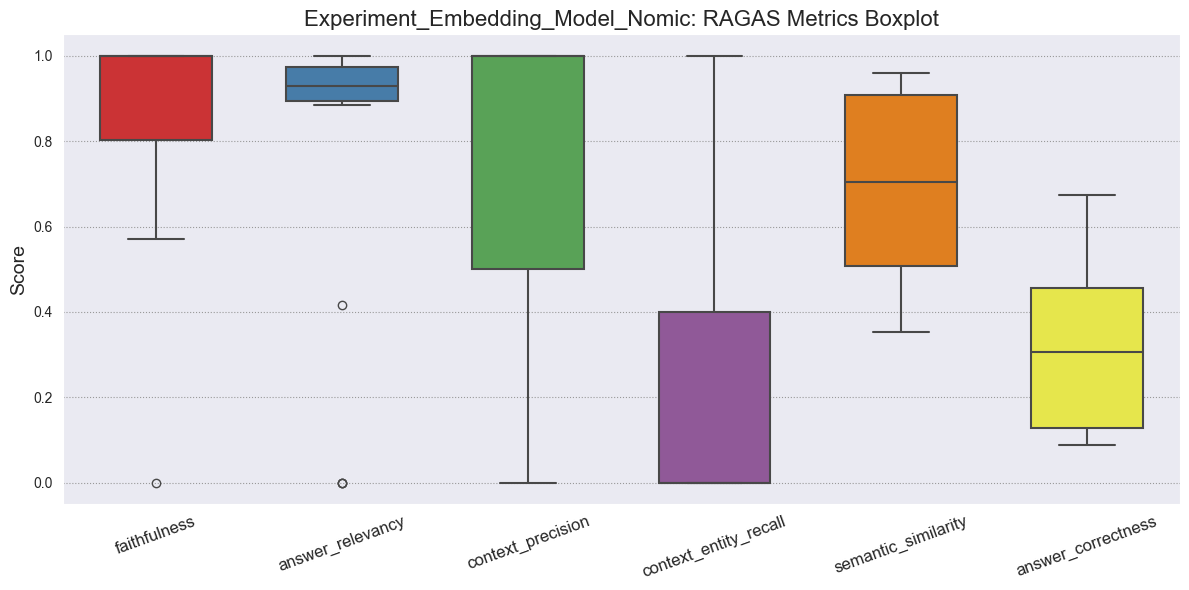

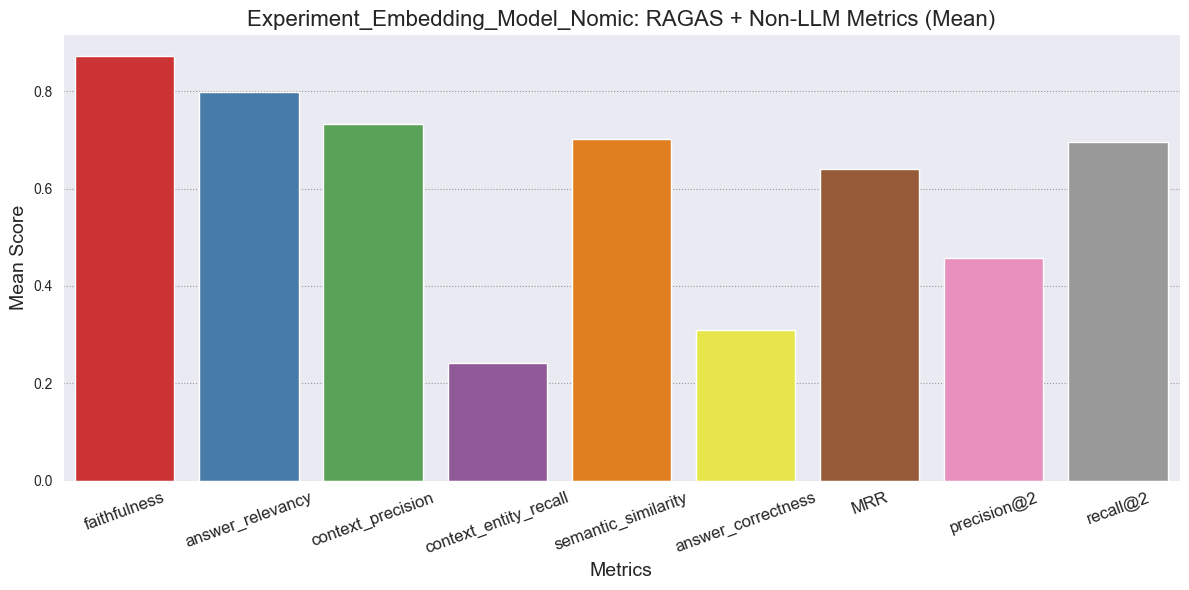

In [18]:
nomic_model_evaluation.plot_results_all(result_nomic)

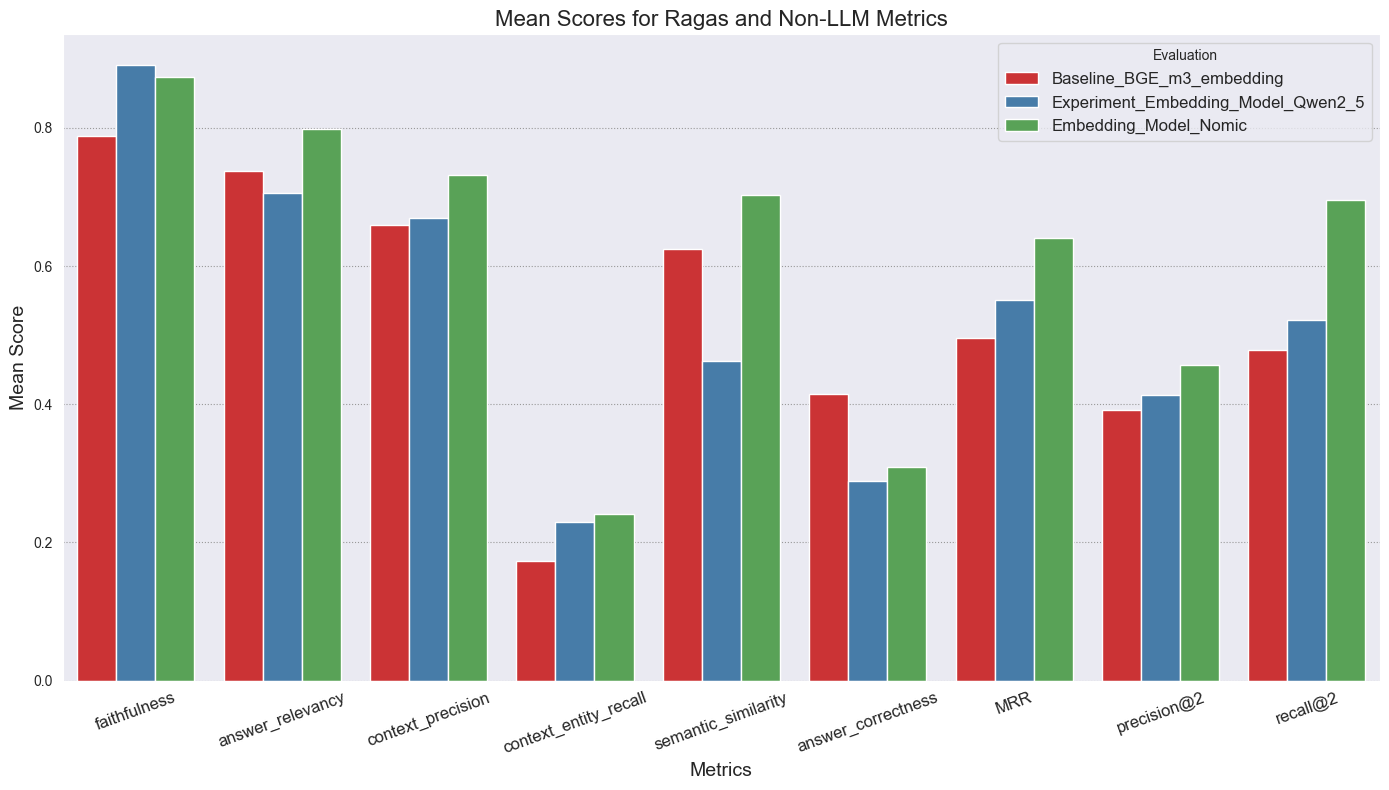

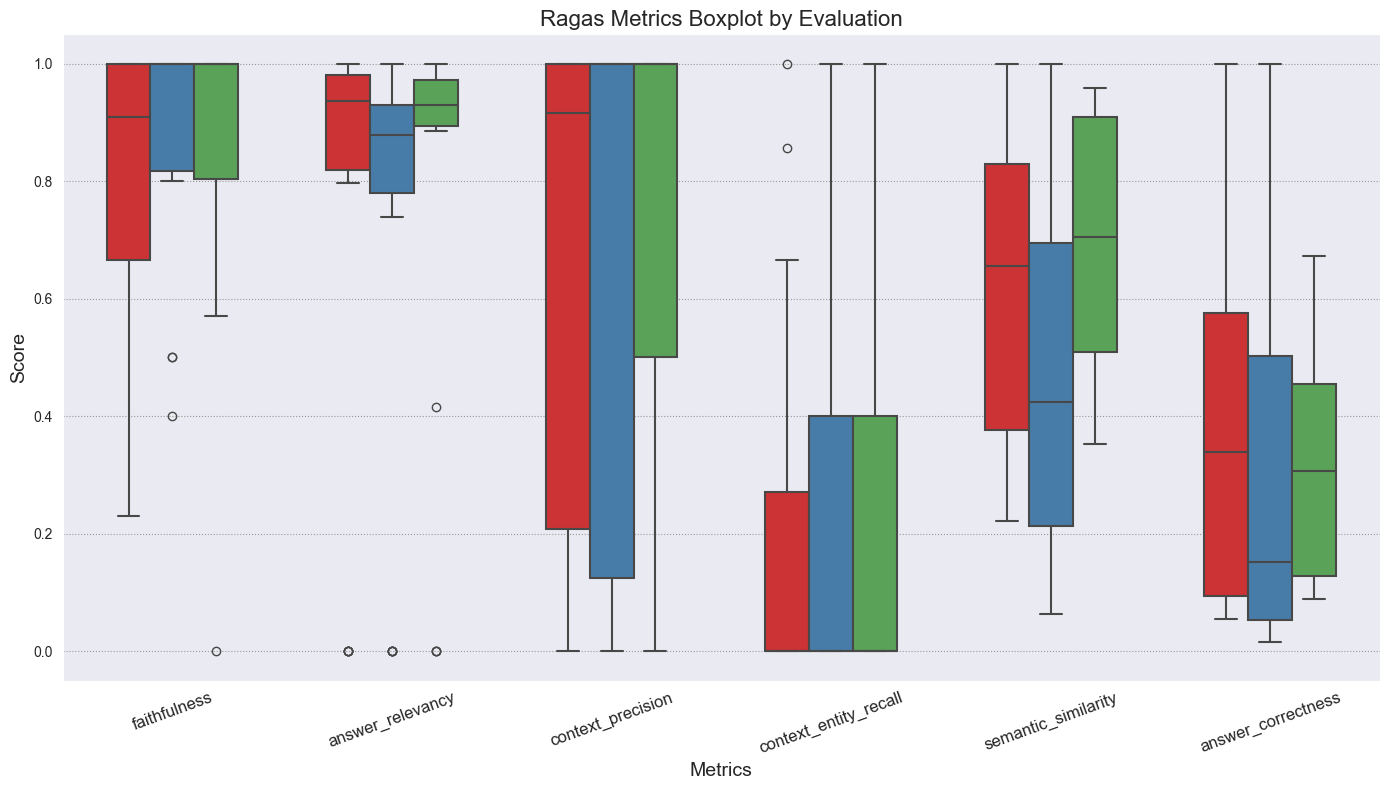

In [19]:
utils.plot_compare_result(combined_df)